# San Francisco Crime Classification

Authors: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql.functions import *

### Load the data

In [2]:
sfcrime = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path","bigdata/Project/dataset/train.csv").load()

In [3]:
sfcrime.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [4]:
# Visualize the data
sfcrime.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

### Data Preprocessing

Steps done in preprocessing:
- feature extraction and pruning
- TODO: transform to categorical dayofweek and pdDiscrit?
- drop duplicate rows
- null removal
- outliers removal

In [4]:
# feature extraction and pruning:
# 1. extract the hour of the day from the timestamp
# 2. extract the month from the timestamp
# 3. extract the year from the timestamp
# 4. drop the 'Dates' column

sfcrime = sfcrime.withColumn('Hour', hour("Dates"))
sfcrime = sfcrime.withColumn('Month', month("Dates"))
sfcrime = sfcrime.withColumn('Year', year("Dates"))
sfcrime = sfcrime.drop("Dates")

#TODO: drop X, Y?

#sfcrime = sfcrime.withColumn('Day',dayofmonth("Dates"))

In [5]:
# drop duplicate rows
prev_count = sfcrime.count()
sfcrime = sfcrime.dropDuplicates()
print("Number of duplicated rows: ", prev_count - sfcrime.count())

Number of duplicated rows:  5680


In [6]:
# nulls removal
sfcrime.na.drop()
print('Total number of records:', sfcrime.count())

Total number of records: 872369


In [ ]:
# Outliers : https://www.kaggle.com/code/bananawolf/random-forest-knn-logistic-regression

## Dataset requirements

In [14]:
# number of features
#TODO


In [12]:
# total number of patterns
print('Total number of records: ', sfcrime.count())

Total number of records:  875726


In [ ]:
#TODO: fare prodotto?

## Dataset inspection

### Distribution of crimes

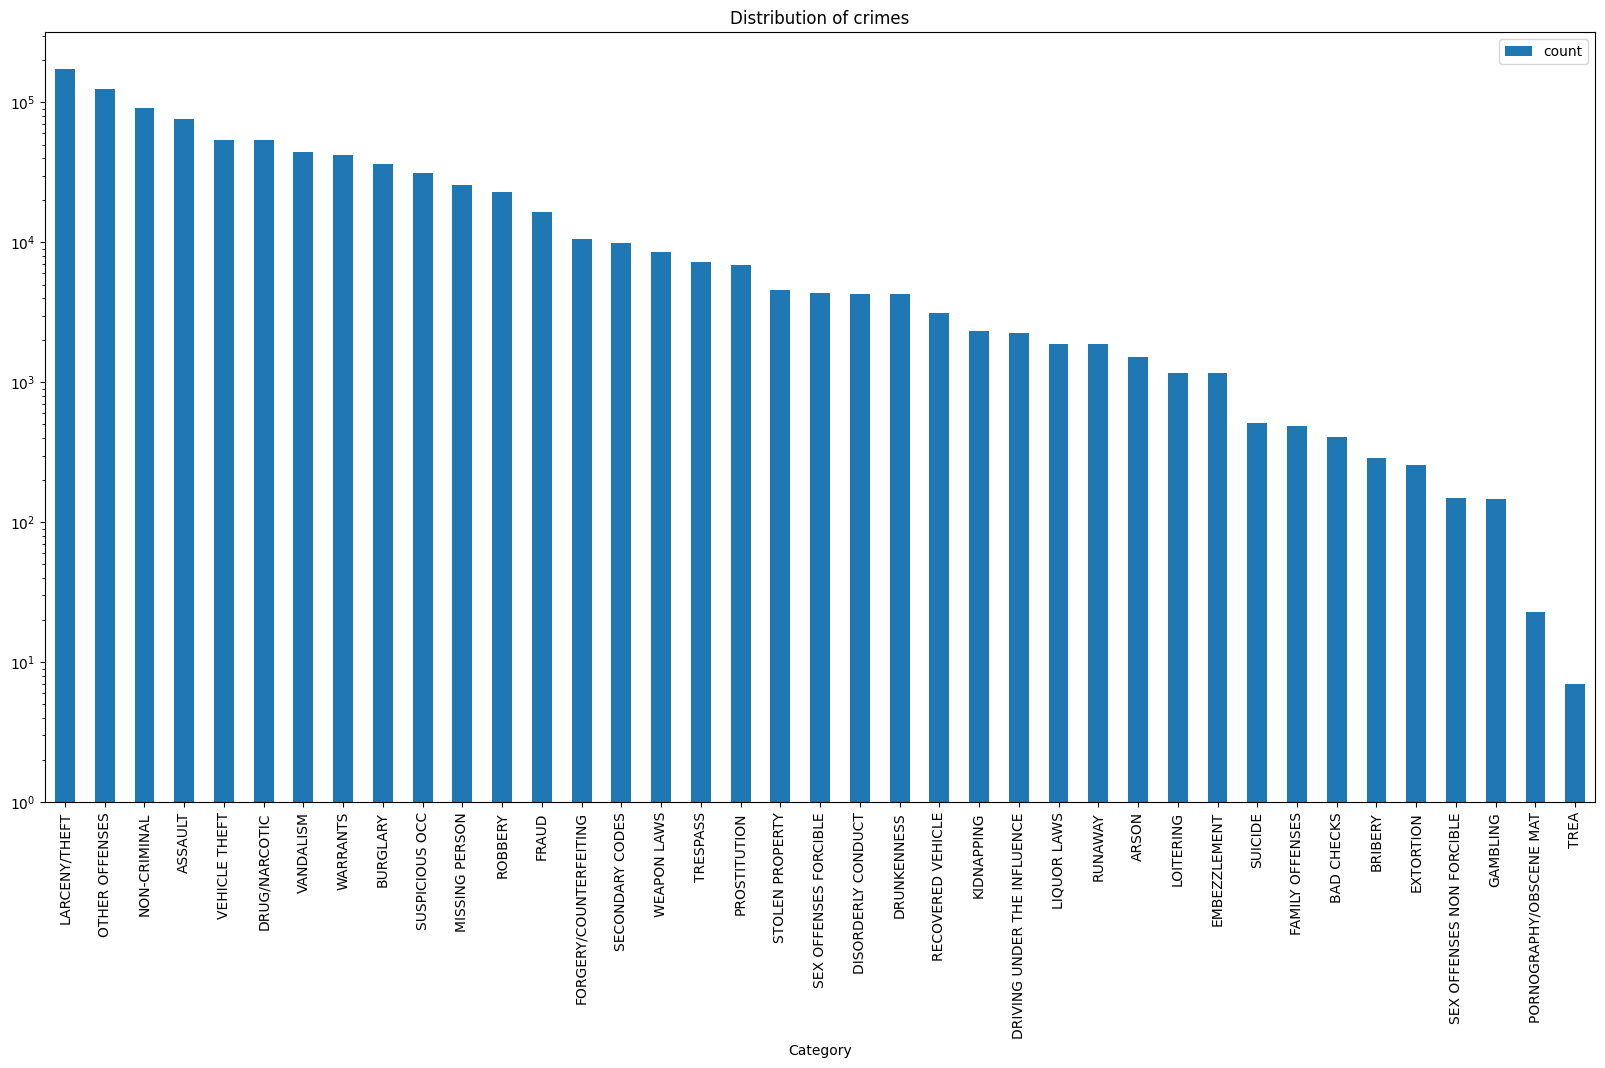

In [16]:
sfcrime.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
plt.title('Distribution of crimes')
plt.show()     

### Distributions of crimes among districts

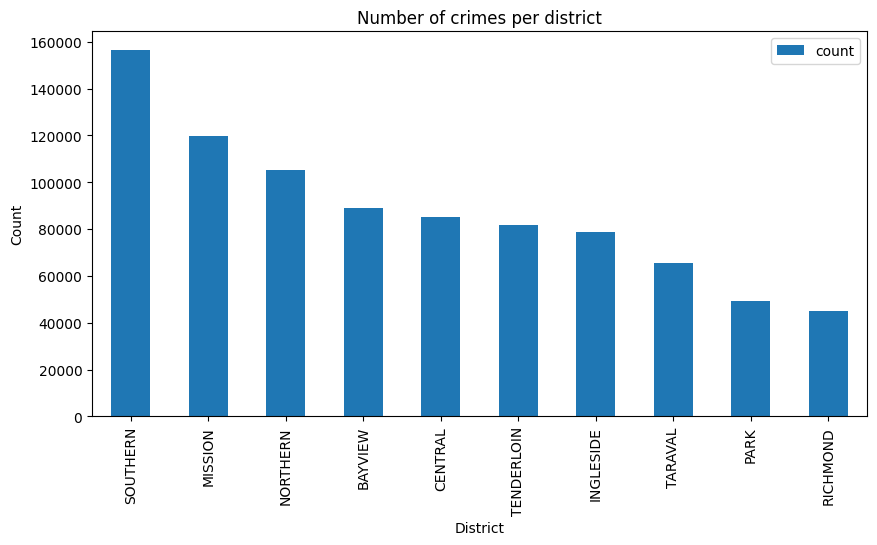

In [21]:
sfcrime.groupBy('PdDistrict').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='PdDistrict', y='count', figsize=(10, 5))
plt.title('Number of crimes per district')
plt.xlabel('District')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='PdDistrict'>

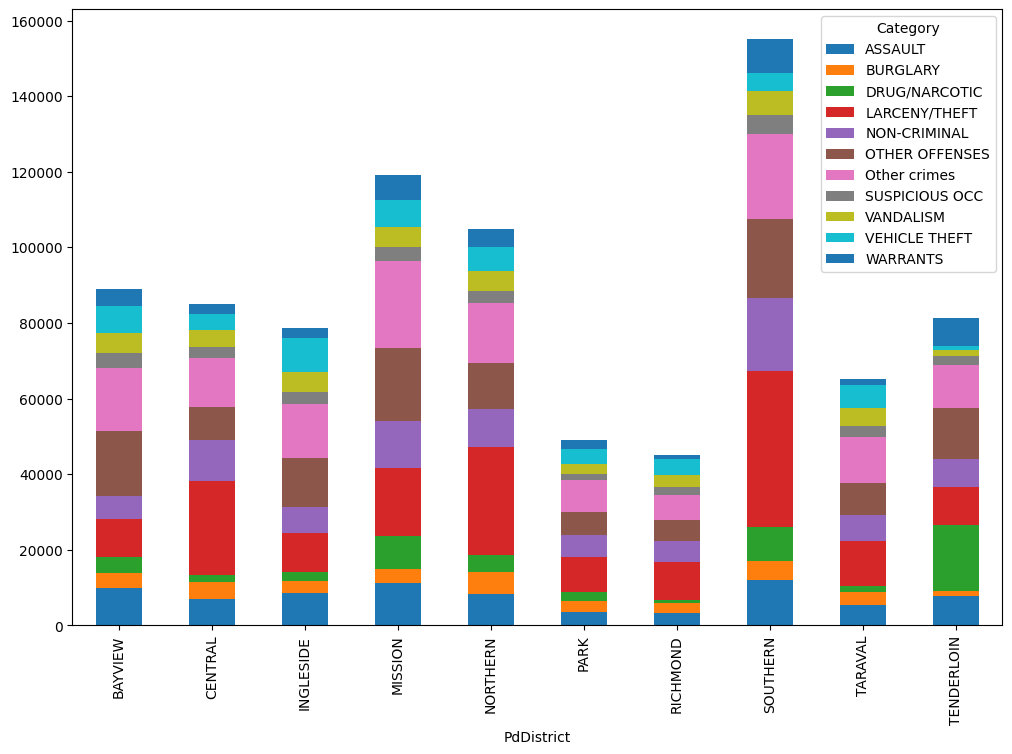

In [18]:
# Analyze the different categories of crimes per district
sfcrime_copy_top_10 = sfcrime.toPandas().copy()

# Select the top 10 crimes and group the rest into 'Other crimes'
top10 = sfcrime_copy_top_10['Category'].value_counts().head(10).index.tolist()
sfcrime_copy_top_10.loc[~sfcrime_copy_top_10['Category'].isin(top10), 'Category'] = 'Other crimes'

# Plot the number of crimes per district for each category
sfcrime_copy_top_10.groupby(['PdDistrict','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
            .plot(kind='bar',stacked=True,figsize=(12,8))


### Distribution of crimes among hours

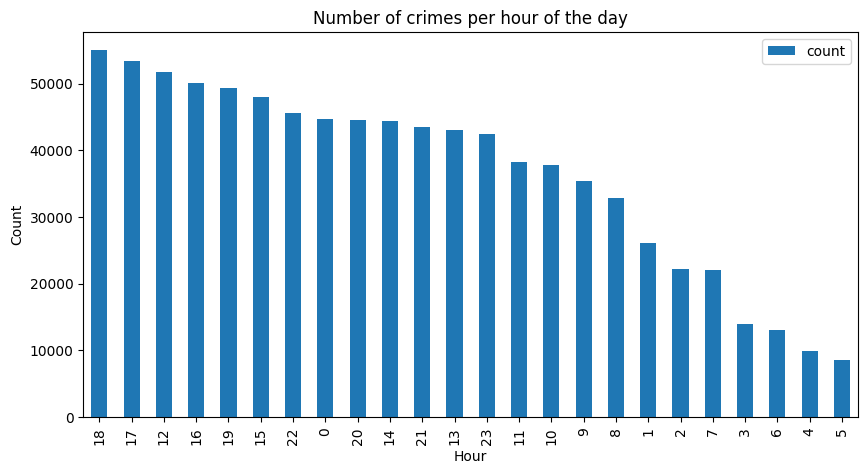

In [23]:
sfcrime.groupBy('Hour').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10, 5))
plt.title('Number of crimes per hour of the day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

### Distribution of crimes among days

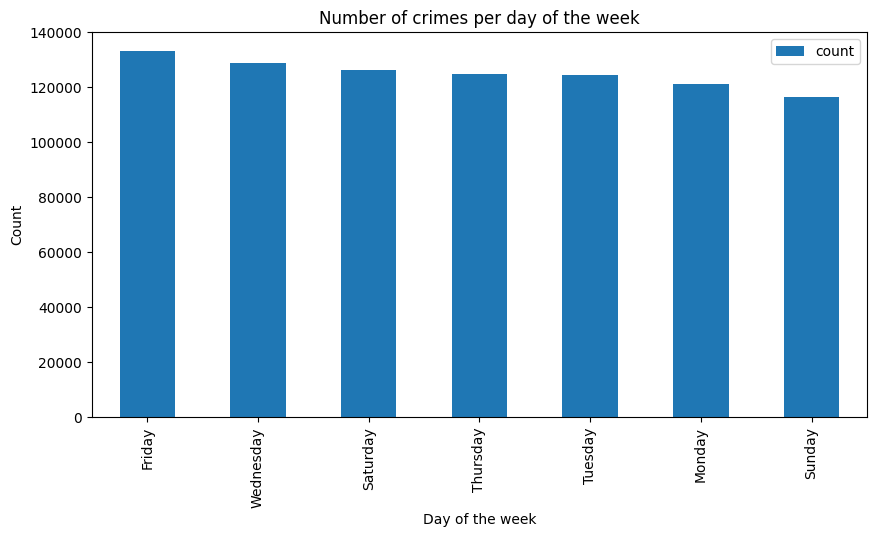

In [68]:
sfcrime.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
plt.title('Number of crimes per day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.show()

In [70]:
sfcrime_copy = sfcrime.toPandas().copy()

<Axes: xlabel='DayOfWeek'>

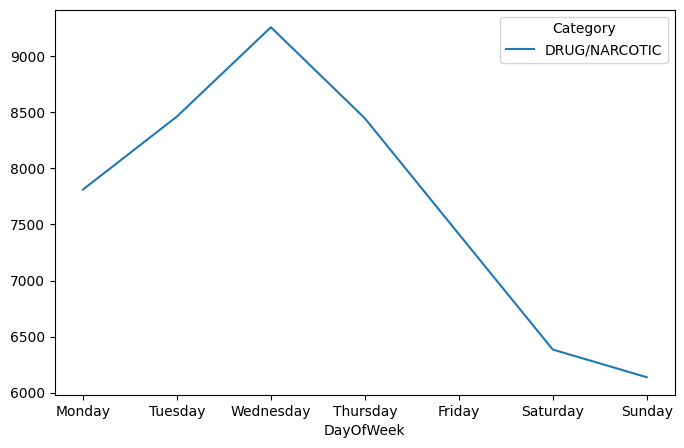

In [73]:
# Trend of the category 'DRUG/NARCOTIC' for each day of the week
sfcrime_drug = sfcrime_copy[sfcrime_copy['Category']=='DRUG/NARCOTIC']
sfcrime_drug.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))

In [ ]:
# function for weekly trend per category 

def weekly_trend(category):
    sfcrime_category = sfcrime_copy[sfcrime_copy['Category']==category]
    sfcrime_category.groupby(['DayOfWeek','Category'])\
                .agg({'Resolution':'count'})\
                .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
                .plot(kind='line',figsize=(8,5))
    plt.title('Weekly trend of the category: ' + category)
    plt.xlabel('Day of the week')
    plt.ylabel('Count')
    plt.show()

# Trend of the category 'DRUG/NARCOTIC' for each day of the week
weekly_trend('DRUG/NARCOTIC')

# Trend of the category 'LARCENY/THEFT' for each day of the week
weekly_trend('LARCENY/THEFT')


<Axes: xlabel='DayOfWeek'>

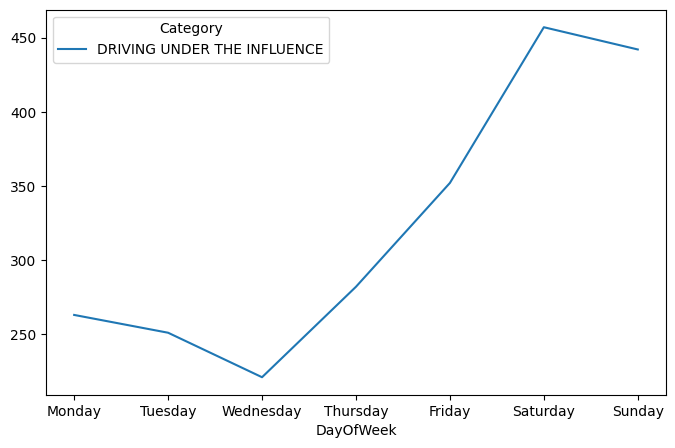

In [55]:
# Trend of the category 'DRIVING UNDER THE INFLUENCE' for each day of the week
sfcrime_drive = sfcrime_copy[sfcrime_copy['Category']=='DRIVING UNDER THE INFLUENCE']
sfcrime_drive.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))

<Axes: xlabel='DayOfWeek'>

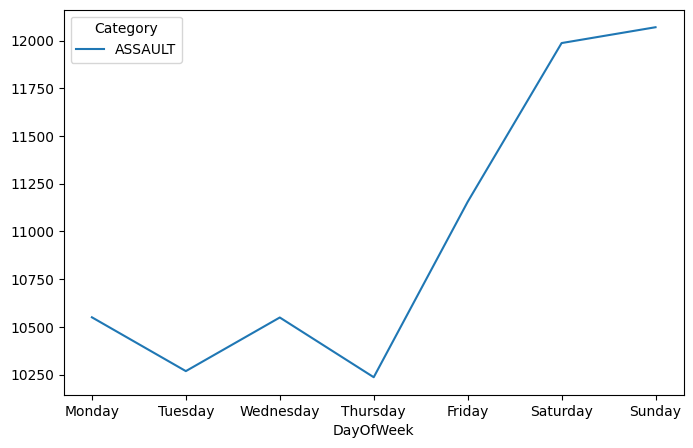

In [58]:
# Trend of the category 'ASSAULT' for each day of the week
sfcrime_assault = sfcrime_copy[sfcrime_copy['Category']=='ASSAULT']
sfcrime_assault.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))

<Axes: xlabel='DayOfWeek'>

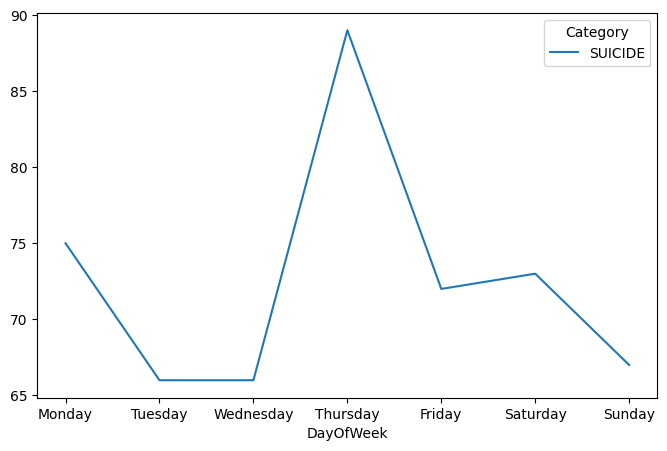

In [63]:
# Trend of the category 'SUICIDE' for each day of the week
sfcrime_suicide = sfcrime_copy[sfcrime_copy['Category']=='SUICIDE']
sfcrime_suicide.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))

<Axes: xlabel='DayOfWeek'>

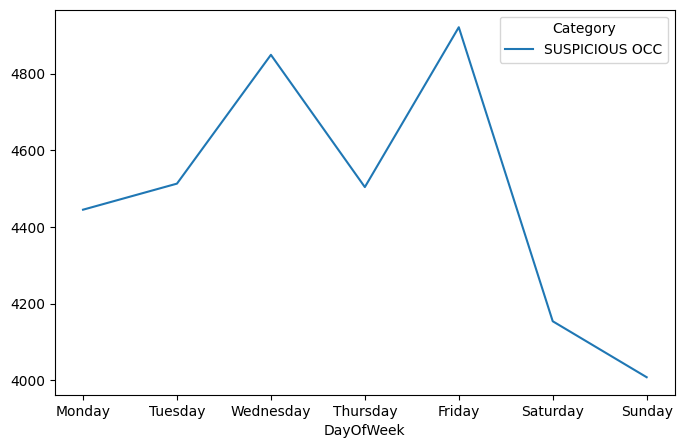

In [65]:
# Trend of the category 'SUSPICIOUS OCC' for each day of the week
sfcrime_occ = sfcrime_copy[sfcrime_copy['Category']=='SUSPICIOUS OCC']
sfcrime_occ.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))

### Distribution of crimes among years

<Axes: xlabel='Year'>

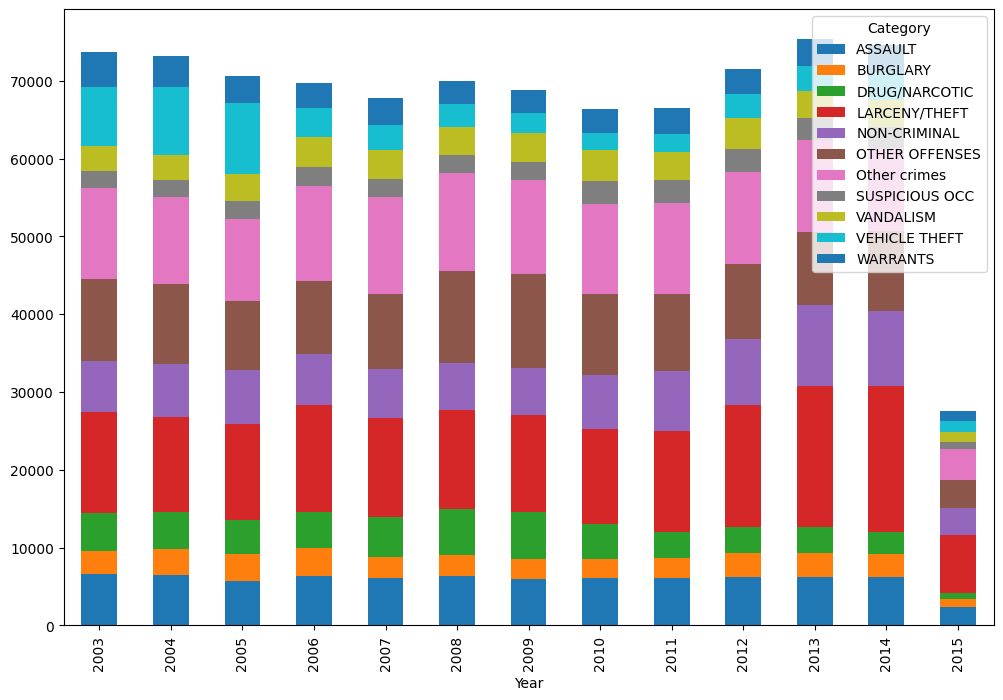

In [79]:
# Plot the number of crimes per year for each category
sfcrime_copy_top_10.groupby(['Year','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='Year',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))

In [ ]:
# TODO: perche nel 2015 cosi pochi?

### Distribution of crimes among different addresses

<Axes: xlabel='Address'>

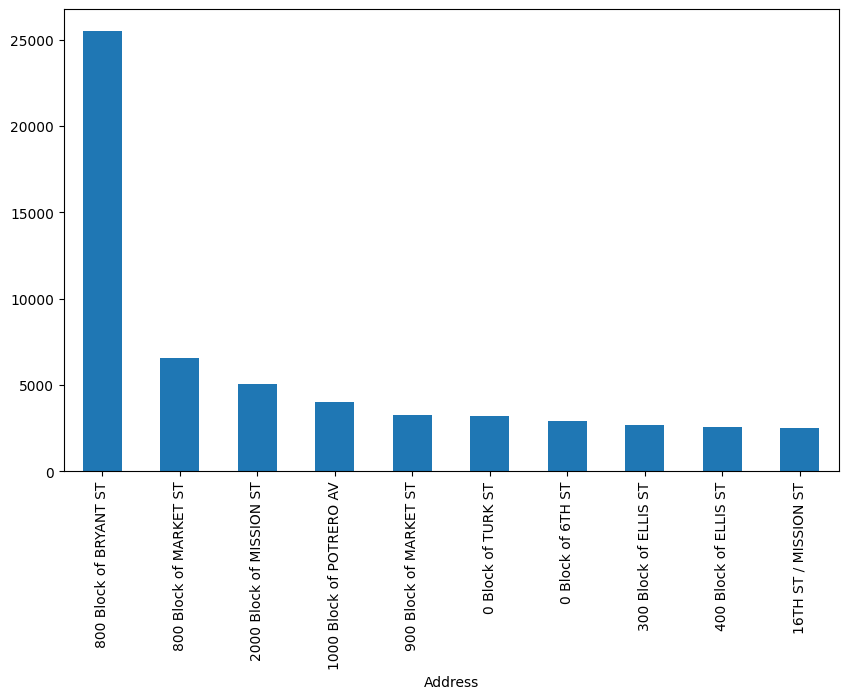

In [20]:
# Show the addresses where the most crimes have been committed
sfcrime_copy_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))


#### TODO: la maggior parte hanno la parola block quindi magari è importante ecc.. e si puo aggiungere come feauture togliendo l'address

In [ ]:
# How the crimes have been resolved?

In [7]:
#Street number extraction as integer value
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def street_no(address):
    try:
        return int(address.split(' ')[0])
    except:
        return 0

street_no_udf = udf(street_no, IntegerType())
df = df.withColumn('StreetNo', street_no_udf(df['Address']))
df.show()

+-------------------+---------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+---+----+--------+
|              Dates|       Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|Year|Month|Day|Hour|StreetNo|
+-------------------+---------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+---+----+--------+
|2015-05-13 19:30:00|  LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  SOUTHERN|          NONE|500 Block of BRAN...|  -122.397615567933|  37.7773918242817|2015|    5| 13|  19|     500|
|2015-05-12 19:00:00|       BURGLARY|BURGLARY, HOT PRO...|  Tuesday|   TARAVAL|          NONE|2100 Block of 43R...|   -122.50180154774| 37.74655644758779|2015|    5| 12|  19|    2100|
|2015-05-11 19:45:00|        ASSAULT|             BATTERY|   Monday|   MISSION| 

In [9]:
#Block feature extraction: 1 if block present, 0 otherwise
df = df.withColumn('Block', when(df.Address.like("%Block%") , lit(1)).otherwise(lit(0)))
df.show()

+-------------------+---------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+---+----+--------+-----+
|              Dates|       Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|Year|Month|Day|Hour|StreetNo|Block|
+-------------------+---------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+---+----+--------+-----+
|2015-05-13 19:30:00|  LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  SOUTHERN|          NONE|500 Block of BRAN...|  -122.397615567933|  37.7773918242817|2015|    5| 13|  19|     500|    1|
|2015-05-12 19:00:00|       BURGLARY|BURGLARY, HOT PRO...|  Tuesday|   TARAVAL|          NONE|2100 Block of 43R...|   -122.50180154774| 37.74655644758779|2015|    5| 12|  19|    2100|    1|
|2015-05-11 19:45:00|        ASSAULT|             